# Plot a confidence ellipse of a two-dimensional dataset

Plot a confidence ellipse of a two-dimensional dataset
This example shows how to plot a confidence ellipse of a two-dimensional dataset, using its pearson correlation coefficient.

The approach that is used to obtain the correct geometry is explained and proved here:

https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

The method avoids the use of an iterative eigen decomposition algorithm and makes use of the fact that a normalized covariance matrix (composed of pearson correlation coefficients and ones) is particularly easy to handle.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

%matplotlib inline

## The plotting function itself

This function plots the confidence ellipse of the covariance of the given array-like variables x and y. The ellipse is plotted into the given axes-object ax.

The radiuses of the ellipse can be controlled by n_std which is the number of standard deviations. The default value is 3 which makes the ellipse enclose 99.7% of the points (given the data is normally distributed like in these examples).

In [8]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## A helper function to create a correlated dataset

Creates a random two-dimesional dataset with the specified two-dimensional mean (mu) and dimensions (scale). The correlation can be controlled by the param 'dependency', a 2x2 matrix.

In [9]:
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

## Positive, negative and weak correlation

Note that the shape for the weak correlation (right) is an ellipse, not a circle because x and y are differently scaled. However, the fact that x and y are uncorrelated is shown by the axes of the ellipse being aligned with the x- and y-axis of the coordinate system.

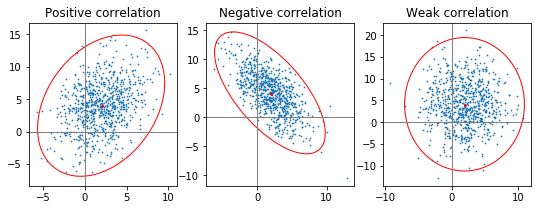

In [10]:
np.random.seed(0)

PARAMETERS = {
    'Positive correlation': np.array([[0.85, 0.35],
                                      [0.15, -0.65]]),
    'Negative correlation': np.array([[0.9, -0.4],
                                      [0.1, -0.6]]),
    'Weak correlation': np.array([[1, 0],
                                  [0, 1]]),
}

mu = 2, 4
scale = 3, 5

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for ax, (title, dependency) in zip(axs, PARAMETERS.items()):
    x, y = get_correlated_dataset(800, dependency, mu, scale)
    ax.scatter(x, y, s=0.5)

    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)

    confidence_ellipse(x, y, ax, edgecolor='red')

    ax.scatter(mu[0], mu[1], c='red', s=3)
    ax.set_title(title)

plt.show()

## Different number of standard deviations

A plot with n_std = 3 (blue), 2 (purple) and 1 (red)

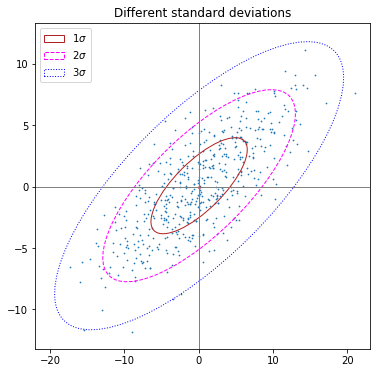

In [11]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = np.array([
    [0.8, 0.75],
    [-0.2, 0.35]
])
mu = 0, 0
scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
ax_nstd.scatter(x, y, s=0.5)

confidence_ellipse(x, y, ax_nstd, n_std=1,
    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
    label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
    label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

## Using the keyword arguments

Use the kwargs specified for matplotlib.patches.Patch in order to have the ellipse rendered in different ways.

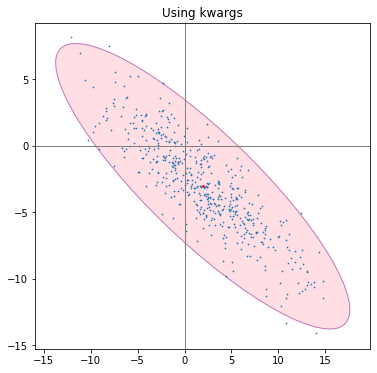

In [12]:
fig, ax_kwargs = plt.subplots(figsize=(6, 6))
dependency_kwargs = np.array([
    [-0.8, 0.5],
    [-0.2, 0.5]
])
mu = 2, -3
scale = 6, 5

ax_kwargs.axvline(c='grey', lw=1)
ax_kwargs.axhline(c='grey', lw=1)

x, y = get_correlated_dataset(500, dependency_kwargs, mu, scale)
# Plot the ellipse with zorder=0 in order to demonstrate
# its transparency (caused by the use of alpha).
confidence_ellipse(x, y, ax_kwargs,
    alpha=0.5, facecolor='pink', edgecolor='purple', zorder=0)

ax_kwargs.scatter(x, y, s=0.5)
ax_kwargs.scatter(mu[0], mu[1], c='red', s=3)
ax_kwargs.set_title('Using kwargs')

fig.subplots_adjust(hspace=0.25)
plt.show()